## 正则化与过拟合
### ✅ 用 make_regression 生成高维数据（如 100 特征，50 样本 → 容易过拟合）
### ✅ 分别训练：
### 普通线性回归
### Ridge 回归（L2）
### Lasso 回归（L1）
### ✅ 比较训练/测试误差
### ✅ 画出 Lasso 的系数变化（随 alpha 增大，哪些系数变为 0？）
### 🔍 思考：L1 为什么能做特征选择？

In [32]:
# 第3天：正则化与过拟合 —— Ridge (L2) vs Lasso (L1)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

SEED = 25

# 1. 生成高维、小样本数据（容易过拟合！）
# 特征数 > 样本数 → 普通线性回归会严重过拟合
np.random.seed(SEED)
X, y = make_regression(
    n_samples=50,      # 只有 50 个样本
    n_features=100,    # 但有 100 个特征！→ 高维小样本
    noise=10,          # 加入噪声
    random_state=SEED
)

print(f"数据形状: X={X.shape}, y={y.shape}")
print("⚠️ 特征数 (100) > 样本数 (50) → 普通线性回归会过拟合！")


数据形状: X=(50, 100), y=(50,)
⚠️ 特征数 (100) > 样本数 (50) → 普通线性回归会过拟合！


In [33]:
# 2. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

# 3. 标准化特征Z-score（正则化对特征尺度敏感！必须做）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. 定义模型
models = {
    "Linear Regression": LinearRegression(),
    "Ridge (L2)": Ridge(alpha=10.0),   # alpha 越大，正则化越强
    "Lasso (L1)": Lasso(alpha=1.0, max_iter=10000)  # Lasso 收敛慢，需增加迭代次数
}



Linear Regression:
  训练 MSE: 0.00
  测试 MSE: 27235.82
  过拟合？: 是

Ridge (L2):
  训练 MSE: 315.98
  测试 MSE: 24594.30
  过拟合？: 是

Lasso (L1):
  训练 MSE: 23.94
  测试 MSE: 845.41
  过拟合？: 是


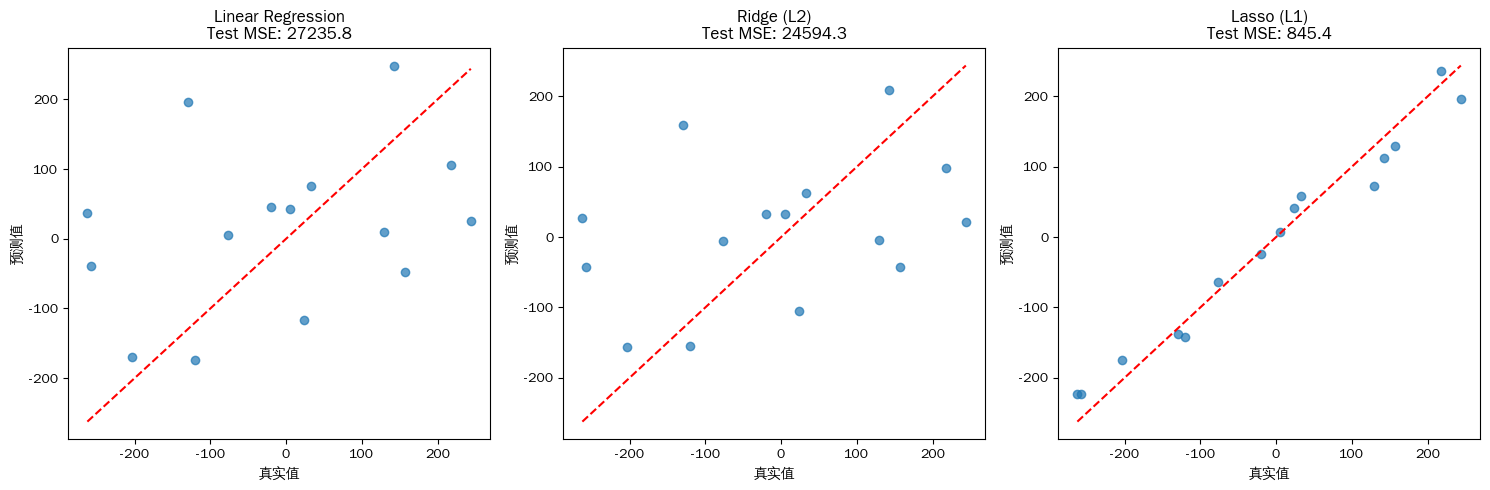

In [34]:
# 5. 训练并评估每个模型
results = {}

plt.figure(figsize=(15, 5))

for i, (name, model) in enumerate(models.items()):
    # 训练
    model.fit(X_train_scaled, y_train)

    # 预测
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # 计算误差
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    results[name] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'coef': model.coef_.copy()  # 保存系数用于可视化
    }

    print(f"\n{name}:")
    print(f"  训练 MSE: {train_mse:.2f}")
    print(f"  测试 MSE: {test_mse:.2f}")
    print(f"  过拟合？: {'是' if train_mse < test_mse else '否'}")

    # 子图1：预测值 vs 真实值（测试集）
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test, y_test_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f"{name}\nTest MSE: {test_mse:.1f}")
    plt.xlabel("真实值")
    plt.ylabel("预测值")

plt.tight_layout()
plt.show()

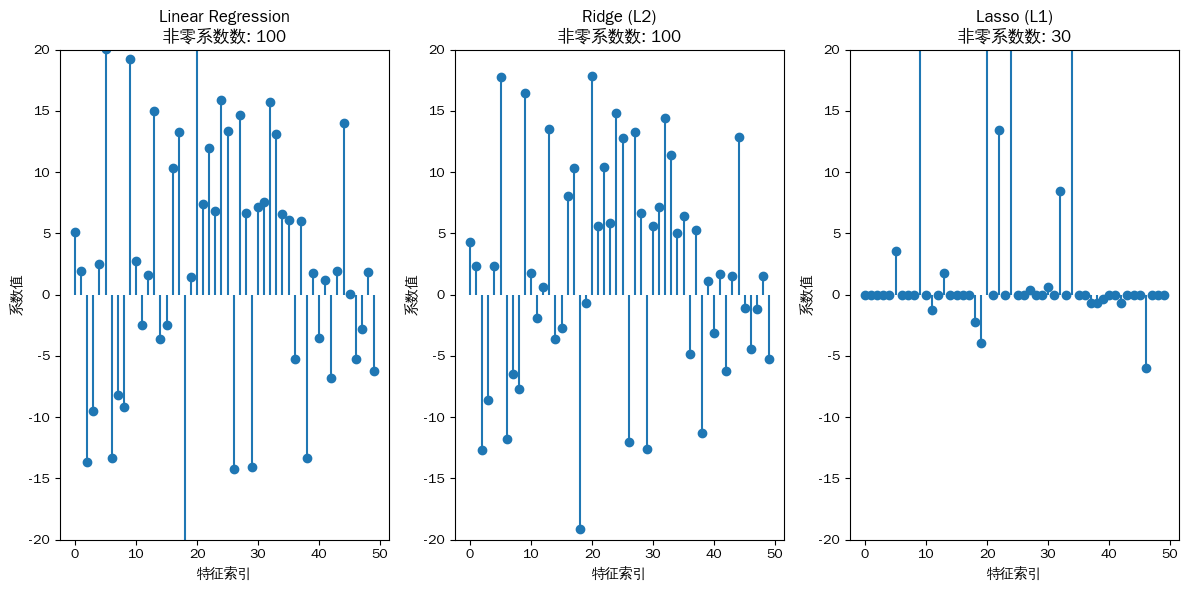

In [35]:
# 6. 【重点】可视化系数：看正则化如何“压缩”或“清零”系数
plt.figure(figsize=(12, 6))

# 获取所有模型的系数
coefs = [results[name]['coef'] for name in models.keys()]
names = list(models.keys())

# 画出每个模型的系数（前50个特征为例）
feature_idx = np.arange(50)  # 只看前50个特征，避免太乱

for i, (name, coef) in enumerate(zip(names, coefs)):
    plt.subplot(1, 3, i+1)
    plt.stem(feature_idx, coef[:50], basefmt=" ")
    plt.title(f"{name}\n非零系数数: {np.sum(coef != 0)}")
    plt.xlabel("特征索引")
    plt.ylabel("系数值")
    plt.ylim(-20, 20)  # 统一纵轴范围，便于比较

plt.tight_layout()
plt.show()


🔍 观察 Lasso 随 alpha 增大的变化：


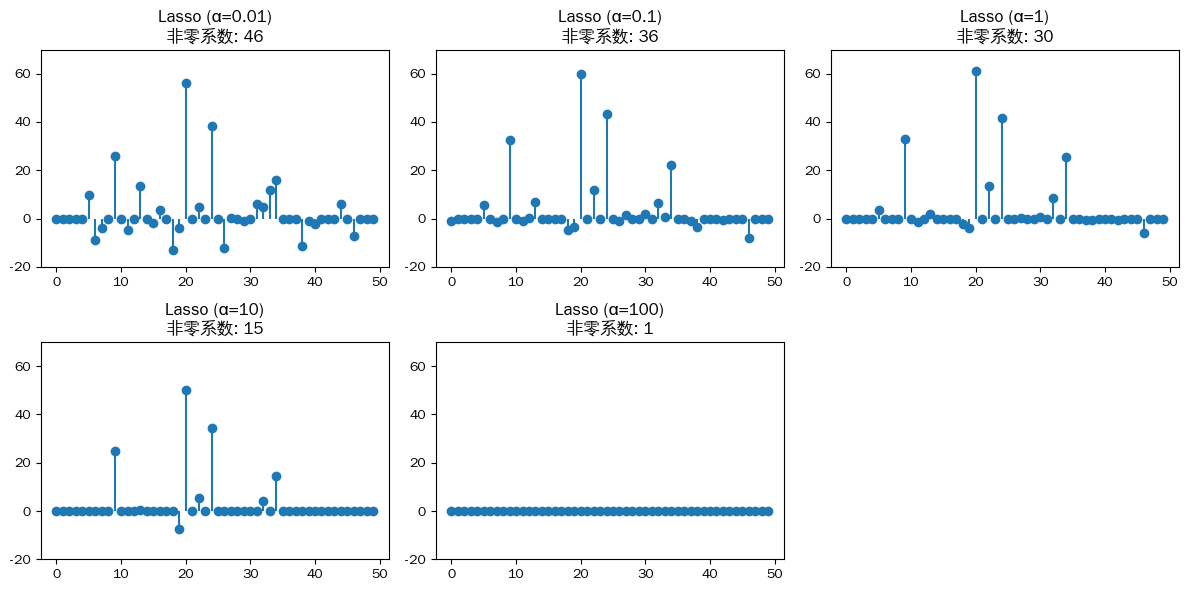

In [36]:
# 7. 【进阶】观察 Lasso 如何随 alpha 增大“稀疏化”系数
print("\n🔍 观察 Lasso 随 alpha 增大的变化：")
alphas = [0.01, 0.1, 1, 10, 100]
plt.figure(figsize=(12, 6))

for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    non_zero = np.sum(lasso.coef_ != 0)

    plt.subplot(2, 3, i+1)
    plt.stem(feature_idx, lasso.coef_[:50], basefmt=" ")
    plt.title(f"Lasso (α={alpha})\n非零系数: {non_zero}")
    plt.ylim(-20, 70)

plt.tight_layout()
plt.show()